# Gate Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
# File paths
binary_file = "Verilog/binary/programs/program_gate_counts.csv"
ternary_file = "Verilog/ternary/programs/program_gate_counts.csv"

Binary gate counts: {'NOT': 82, 'AND': 738, 'OR': 224, 'XOR': 738}
Ternary gate counts: {'NOT': 479, 'AND': 175, 'OR': 175, 'XOR': 175, 'ANY': 4207, 'CONSENSUS': 2422}


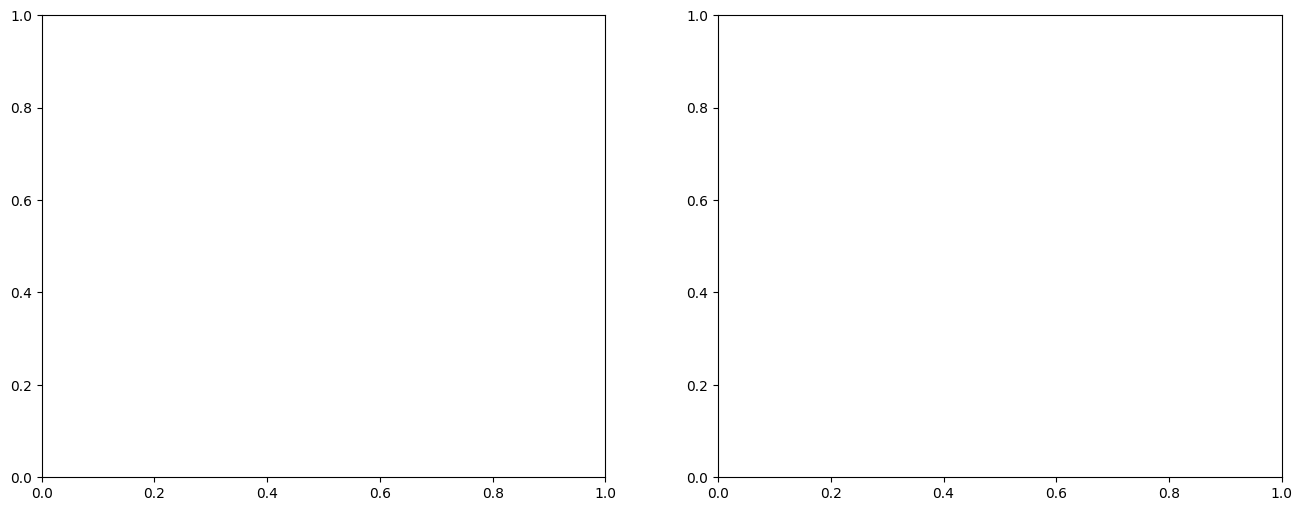

In [ ]:
# Function to parse the gate count files
def parse_gate_count_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Parse the data using regex
    # Looking for patterns like "NOT,82", "AND,738", etc.
    matches = re.findall(r'(\w+),(\d+)', content)
    
    # Convert to dictionary
    gate_counts = {gate: int(count) for gate, count in matches}
    
    return gate_counts

# Parse both files
try:
    binary_counts = parse_gate_count_file(binary_file)
    ternary_counts = parse_gate_count_file(ternary_file)
    
    print("Binary gate counts:", binary_counts)
    print("Ternary gate counts:", ternary_counts)
    
    # Create a DataFrame for easier plotting
    all_gates = sorted(set(list(binary_counts.keys()) + list(ternary_counts.keys())))
    
    data = {
        'Gate': all_gates,
        'Binary': [binary_counts.get(gate, 0) for gate in all_gates],
        'Ternary': [ternary_counts.get(gate, 0) for gate in all_gates]
    }
    
    df = pd.DataFrame(data)

    return df
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please verify that the file paths are correct.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
# 1. Bar chart comparison
x = np.arange(len(all_gates))
width = 0.35

ax1.bar(x - width/2, df['Binary'], width, label='Binary')
ax1.bar(x + width/2, df['Ternary'], width, label='Ternary')

ax1.set_xticks(x)
ax1.set_xticklabels(all_gates)
ax1.set_ylabel('Count')
ax1.set_title('Gate Usage Comparison: Binary vs Ternary')
ax1.legend()

# Add count labels on top of each bar
for i, v in enumerate(df['Binary']):
    ax1.text(i - width/2, v + 5, str(v), ha='center')

for i, v in enumerate(df['Ternary']):
    ax1.text(i + width/2, v + 5, str(v), ha='center')

In [ ]:
# 2. Pie charts
binary_total = sum(binary_counts.values())
ternary_total = sum(ternary_counts.values())

binary_labels = [f"{gate}\n({count}, {count/binary_total:.1%})" for gate, count in binary_counts.items()]
ternary_labels = [f"{gate}\n({count}, {count/ternary_total:.1%})" for gate, count in ternary_counts.items()]

ax2.pie(binary_counts.values(), labels=binary_labels, autopct='', startangle=90, 
        wedgeprops={'alpha': 0.6}, radius=1)
ax2.pie(ternary_counts.values(), labels=ternary_labels, autopct='', startangle=90, 
        wedgeprops={'alpha': 0.6}, radius=0.7)

centre_circle = plt.Circle((0, 0), 0.4, fc='white')
ax2.add_patch(centre_circle)

ax2.set_title('Gate Distribution (Outer: Binary, Inner: Ternary)')

# Add a title for the whole figure
plt.suptitle('Binary vs Ternary Logic: Gate Usage Analysis', fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
# 3. Ratio comparison (separate visualization)
plt.figure(figsize=(10, 6))

ratios = []
for gate in all_gates:
    binary_val = binary_counts.get(gate, 0)
    ternary_val = ternary_counts.get(gate, 0)
    
    # Avoid division by zero
    if binary_val > 0 and ternary_val > 0:
        ratio = ternary_val / binary_val
        ratios.append((gate, ratio))

if ratios:
    ratios.sort(key=lambda x: x[1], reverse=True)
    gates_with_ratios, ratio_values = zip(*ratios)
    
    plt.bar(gates_with_ratios, ratio_values, color='purple')
    plt.axhline(y=1, color='r', linestyle='-', alpha=0.3)
    
    plt.title('Ternary/Binary Gate Usage Ratio')
    plt.ylabel('Ratio (Ternary ÷ Binary)')
    plt.xticks(rotation=45)
    
    # Add ratio values on top of each bar
    for i, v in enumerate(ratio_values):
        plt.text(i, v + 0.05, f"{v:.2f}x", ha='center')
    
    plt.tight_layout()
    plt.show()